In [1]:
using DrWatson
@quickactivate "DrivenKerrResonator"

using HarmonicBalance
using Symbolics

In [9]:
# defining variables
@variables αᵣ₁::Real,αᵢ₁::Real,αᵣ₂::Real,αᵢ₂::Real
@variables Δ::Real,κ::Real,U::Real, F::Real, J::Real
@variables α₁::Complex{Real},α₂::Complex{Real}

# accounting for the fact that we "divide" each complex equation in its real and imaginary part
function replace_split(f,sub_rules)
    exp = substitute(real(f),sub_rules) + 1.0im*substitute(imag(f),sub_rules)
    [real(exp),imag(exp)]
end

function get_EOM_full()
    K₁ = (-Δ + conj(α₁)*α₁ - 1.0im*κ/2)*α₁ + F*sqrt(U)
    K₂ = (-Δ + conj(α₂)*α₂ - 1.0im*κ/2)*α₂ 
    
    fψ₁ =   -1.0im*(K₁ - J*α₂) 
    fψ₂ =   -1.0im*(K₂ - J*α₁) 
    
    sub_rules = Dict((real(α₁)=>αᵣ₁),(imag(α₁)=>αᵢ₁),(real(α₂)=>αᵣ₂),(imag(α₂)=>αᵢ₂))

    variables = [αᵣ₁,αᵢ₁,αᵣ₂,αᵢ₂]
    parameters = [Δ,κ,U,F,J]
    system_f= reduce(vcat,[replace_split(f,sub_rules) for f in [fψ₁,fψ₂]])

    equation_HC = HarmonicBalance.Problem(system_f,variables,parameters);
    return equation_HC
end


MF_eqs = get_EOM_full()


###Hot fix required for the eom field in the harmonic equations object to not be empty. 
###Will be corrected in future versions
# declare dummy system: declare constant variables and two functions x(t) and y(t)
@variables α, ω, ω0, t, η, x(t), y(t)

# differential equations
diff_eq = DifferentialEquation([d(x,t,2) + ω0^2*x + α*x^3 + η*d(x,t)*x^2 ~ 0,
                                d(y,t,2) + ω0^2*y + α*y^3 + η*d(y,t)*y^2 ~ 0], [x,y])

# specify the harmonic ansatz for x and y: x = u(T) cos(ωt) + v(T) sin(ωt)
add_harmonic!(diff_eq, x, ω)
add_harmonic!(diff_eq, y, ω)

# implement ansatz to get harmonic equations
harmonic_eq_dummy = get_harmonic_equations(diff_eq)

MF_eqs.eom = harmonic_eq_dummy;
MF_eqs.system

System of length 4
 4 variables: αᵣ₁, αᵢ₁, αᵣ₂, αᵢ₂
 5 parameters: Δ, κ, U, F, J

 -J*αᵢ₂ - 0.5*κ*αᵣ₁ + (-Δ + αᵢ₁^2 + αᵣ₁^2)*αᵢ₁
 -F*sqrt(U) + J*αᵣ₂ - 0.5*κ*αᵢ₁ - (-Δ + αᵢ₁^2 + αᵣ₁^2)*αᵣ₁
 -J*αᵢ₁ - 0.5*κ*αᵣ₂ + (-Δ + αᵢ₂^2 + αᵣ₂^2)*αᵢ₂
 J*αᵣ₁ - 0.5*κ*αᵢ₂ - (-Δ + αᵢ₂^2 + αᵣ₂^2)*αᵣ₂

In [168]:
# parameters
κᵣ = 1. #reference value for unitless parameters
Uᵣ = 1.
#under these assumptions, Ftilde = F and J/κ = J
fixed = (κ=>κᵣ,Δ=>2*κᵣ,U=>Uᵣ)
varied = (F=>LinRange(0,5,200),J => LinRange(0,2*κᵣ,200))

# results
result = get_steady_states(MF_eqs, varied, fixed)


Solving for 40000 parameters... 100%|███████████████████| Time: 0:00:34
  # parameters solved:  40000
  # paths tracked:      360000


A steady state result for 40000 parameter points

Solution branches:   9
   of which real:    7
   of which stable:  6

Classes: stable, physical, Hopf, binary_labels


## Phase diagrams

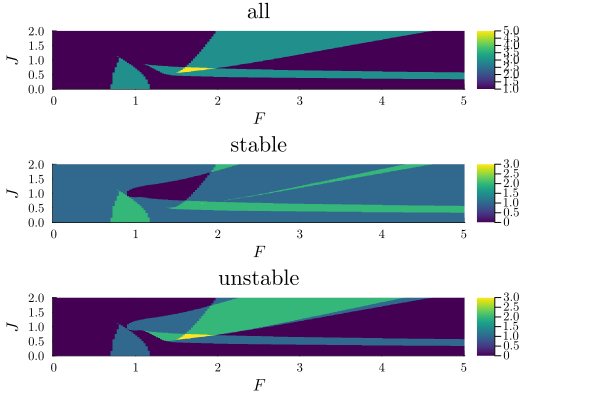

In [169]:
p1 = plot_phase_diagram(result,title="all")
p2 = plot_phase_diagram(result,class="stable",title="stable")
p3 = plot_phase_diagram(result,not_class="stable",title="unstable")
plot([p1,p2,p3]...,layout = (3,1),figsize = (24,20))

## Replace RWA by harmonic balance around the driving frequency: The previous phase diagram can be recovered at a new effective detuning

In [205]:
@variables α, ω, ω0, t, γ, x(t), y(t)

# differential equations
diffeq_beyond_RWA = DifferentialEquation([d(x,t,2) + γ*d(x,t,1) + ω0^2*x + α*x^3 - J*y ~ F*sqrt(U)*sin(ω*t),
                                d(y,t,2) + γ*d(y,t,1) + ω0^2*y + α*y^3  - J*x ~ 0], [x,y])

# specify the harmonic ansatz for x and y: x = u(T) cos(ωt) + v(T) sin(ωt)
add_harmonic!(diffeq_beyond_RWA, x, ω)
add_harmonic!(diffeq_beyond_RWA, y, ω)


MF_eqs_beyond_RWA = get_harmonic_equations(diffeq_beyond_RWA)

A set of 4 harmonic equations
Variables: u1(T), v1(T), u2(T), v2(T)
Parameters: α, ω, γ, ω0, J, F, U

Harmonic ansatz: 
x(t) = u1(T)*cos(ωt) + v1(T)*sin(ωt)
y(t) = u2(T)*cos(ωt) + v2(T)*sin(ωt)

Harmonic equations:

γ*Differential(T)(u1(T)) + (ω0^2)*u1(T) + (3//4)*α*(u1(T)^3) + γ*ω*v1(T) + (2//1)*ω*Differential(T)(v1(T)) + (3//4)*α*(v1(T)^2)*u1(T) - J*u2(T) - (ω^2)*u1(T) ~ 0

(ω0^2)*v1(T) + γ*Differential(T)(v1(T)) + (3//4)*α*(v1(T)^3) + (3//4)*α*(u1(T)^2)*v1(T) - J*v2(T) - (ω^2)*v1(T) - (2//1)*ω*Differential(T)(u1(T)) - γ*ω*u1(T) ~ F*sqrt(U)

γ*Differential(T)(u2(T)) + (ω0^2)*u2(T) + (3//4)*α*(u2(T)^3) + γ*ω*v2(T) + (2//1)*ω*Differential(T)(v2(T)) + (3//4)*α*(v2(T)^2)*u2(T) - J*u1(T) - (ω^2)*u2(T) ~ 0

γ*Differential(T)(v2(T)) + (ω0^2)*v2(T) + (3//4)*α*(v2(T)^3) + (3//4)*α*(u2(T)^2)*v2(T) - J*v1(T) - (2//1)*ω*Differential(T)(u2(T)) - (ω^2)*v2(T) - γ*ω*u2(T) ~ 0


Observation: Harmonic Balance equations and regular RWA equations differ in the sign of J. Probably is just the fact the quadratures are rotated in both cases

In [206]:
result.problem.system

System of length 4
 4 variables: αᵣ₁, αᵢ₁, αᵣ₂, αᵢ₂
 5 parameters: Δ, κ, U, F, J

 -J*αᵢ₂ - 0.5*κ*αᵣ₁ + (-Δ + αᵢ₁^2 + αᵣ₁^2)*αᵢ₁
 -F*sqrt(U) + J*αᵣ₂ - 0.5*κ*αᵢ₁ - (-Δ + αᵢ₁^2 + αᵣ₁^2)*αᵣ₁
 -J*αᵢ₁ - 0.5*κ*αᵣ₂ + (-Δ + αᵢ₂^2 + αᵣ₂^2)*αᵢ₂
 J*αᵣ₁ - 0.5*κ*αᵢ₂ - (-Δ + αᵢ₂^2 + αᵣ₂^2)*αᵣ₂

In [207]:
result_beyond_RWA.problem.system

System of length 4
 4 variables: u1, v1, u2, v2
 6 parameters: ω, γ, ω0, J, F, U

 -J*u2 + u1*v1^2 - u1*ω^2 + u1*ω0^2 + v1*γ*ω + u1^3
 -F*sqrt(U) - J*v2 + u1^2*v1 - v1*ω^2 + v1*ω0^2 - u1*γ*ω + v1^3
 -J*u1 + u2*v2^2 - u2*ω^2 + u2*ω0^2 + v2*γ*ω + u2^3
 -J*v1 + u2^2*v2 - v2*ω^2 + v2*ω0^2 - u2*γ*ω + v2^3

In [210]:
# parameters
κᵣ = 1. #reference value for unitless parameters
Uᵣ = 1.
ωᵣ = sqrt(2*κᵣ) #the effective detuning parameter is (ω0^2-ω^2)/ω in the equations 
#under these assumptions, Ftilde = F and J/κ = J
fixed = (γ=>κᵣ/(2*ωᵣ),ω=>ωᵣ,ω0=>0.,α=>(4/3),U=>1)
varied = (F=>LinRange(0.0,5,200),J => LinRange(0.0,2.,200))

# results
result_beyond_RWA = get_steady_states(MF_eqs_beyond_RWA, varied, fixed)


Solving for 40000 parameters... 100%|███████████████████| Time: 0:00:41
  # parameters solved:  40000
  # paths tracked:      360000


A steady state result for 40000 parameter points

Solution branches:   9
   of which real:    7
   of which stable:  7

Classes: stable, physical, Hopf, binary_labels


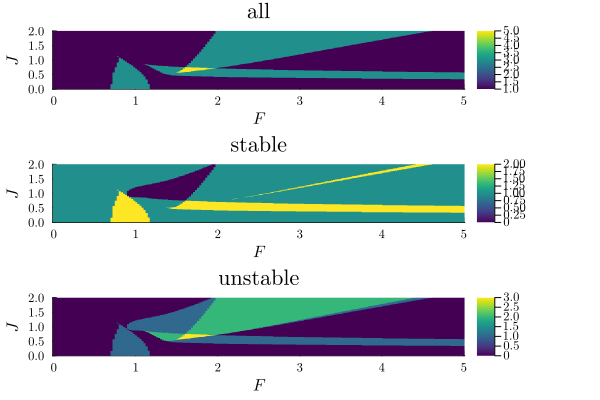

In [211]:
p1 = plot_phase_diagram(result_beyond_RWA ,title="all")
p2 = plot_phase_diagram(result_beyond_RWA ,class="stable",title="stable")
p3 = plot_phase_diagram(result_beyond_RWA ,not_class="stable",title="unstable")
plot([p1,p2,p3]...,layout = (3,1),figsize = (24,20))